In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import pandas as pd
from re import split
from ast import literal_eval
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from re import split
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
import matplotlib.patches as mpatches
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini
from src.ufucnt_xr import lee_filter_new, regridd
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.style.use('ggplot')

In [21]:
def process_new(zhh14, _range, azimuth, alt3d, bin_size, time):
    x = _range * bin_size.values[0] * np.sin(np.deg2rad(azimuth))  # add roll
    y = alt3d
    img_filtered = lee_filter_new(zhh14, size=3, tresh=-180)
    img, xi, yi = regridd(img_filtered, x.values, y.values)
    img = np.where(img > 0., img, 0.)
    blurred = gaussian(img, sigma=0.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    if labels.ndim > 2:
        props = [measure.regionprops(labels[:, :, i]) for i in range(labels.shape[-1])]
        _props_all = [[[j.area for j in prop], [j.perimeter for j in prop], [j.major_axis_length for j in prop],
                       [j.minor_axis_length for j in prop], [j.bbox for j in prop]] for prop in props]
        df = pd.DataFrame(data=_props_all, columns=['area', 'perimeter', 'axmax', 'axmin', 'bbox'],
                          index=pd.to_datetime(time))
        max_zhh14 = np.apply_along_axis(np.max, arr=img,  axis=0).compute()
        df['max_zhh14'] = np.apply_along_axis(np.max, arr=max_zhh14,  axis=0)
    else:
        props = measure.regionprops(labels)
        _props_all = [[[prop.area], [prop.perimeter], [prop.major_axis_length], [prop.minor_axis_length],
                       [prop.bbox]] for prop in props]
        df = pd.DataFrame(data=_props_all, columns=['area', 'perimeter', 'axmax', 'axmin', 'bbox'])
        df['max_zhh14'] = np.max(img)

    if img.ndim > 2:
        shp = img.shape[-1]
        for i in range(shp):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
            img_plot = img[:, :, i]
            ax1.pcolormesh(x.isel(time=i), y.isel(time=i), img_filtered.compute()[:, :, i], cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=50, vmin=0)
            ax3.pcolormesh(xi[:, :, i], yi[:, :, i], img_plot, cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            for region in props[i]:
                if region.area >= 105:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=2)
                    ax2.add_patch(rect)
            plt.show()
            print('a')

    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
        img_plot = img
        ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')
        ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=60, vmin=0)
        ax3.pcolormesh(xi, yi, img_plot, cmap='jet', vmax=60, vmin=0, shading='auto')
        ax3.set_yticks(np.arange(yi.min(), yi.max(), 250))
        for region in props:
            if region.area >= 100:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                ax2.add_patch(rect)
        plt.show()
        print('a')


In [22]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

In [23]:
# cluster.scale(2)
cluster.adapt(minimum=0, maximum=4)
cluster

In [24]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7799/status,
Dashboard: http://172.22.179.3:7799/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7223,Workers: 0
Dashboard: http://172.22.179.3:7799/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [25]:
def literal_converter(val):
    # replace first val with '' or some other null identifier if required
    return val if val == '' else literal_eval(val)

In [26]:
df = pd.read_csv('../results/filtrado_sobre_fechas.csv', parse_dates=['time'], index_col=['time'],
                 converters=dict.fromkeys(['area', 'perimeter', 'ax_max', 'ax_min', 'bbox', 'max_zhh'], 
                                          literal_converter))

In [27]:
df.columns = ['area', 'perimeter', 'depth', 'width', 'bbox', 'max_zhh', 'num_px', 'total_px']

In [28]:
times = list(df.index)

In [29]:
%%time
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())

CPU times: user 773 ms, sys: 82.6 ms, total: 856 ms
Wall time: 1.44 s


In [30]:
ds_data = ds_xr[['alt3D']].sel(time=times)

In [31]:
ds_elevation = ds_data.alt3D.sel(cross_track=12, range=0).to_dataframe()


In [32]:
ds_elevation.head()

,alt3d,cross_track,lat3d,lon3d,alt3D
time,,,,,
2019-08-24 23:05:44.899800,9309.001289,12,17.700525,118.549542,9309.001289
2019-08-24 23:05:46.749800,9308.915433,12,17.703229,118.550230,9308.915433
2019-08-24 23:05:48.599800,9308.541724,12,17.706184,118.550810,9308.541724
2019-08-24 23:05:50.449800,9307.921587,12,17.708798,118.551330,9307.921587
2019-08-24 23:05:52.299800,9307.947854,12,17.711578,118.551991,9307.947854


In [33]:
df = df.merge(ds_elevation, left_index=True, right_index=True)

In [34]:
df.head(2)

,area,perimeter,depth,width,bbox,max_zhh,num_px,total_px,alt3d,cross_track,lat3d,lon3d,alt3D
time,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,[3522],[375.62846301849606],[113.66329687106175],[44.330907079652704],"[(204, 190, 257, 306)]",28.932385,0 1 2 3 ...,0 1 2 3 ...,9309.001289,12,17.700525,118.549542,9309.001289
2019-08-24 23:05:46.749800,[6811],[406.1848122046001],[140.46555565143413],[65.6056998756304],"[(199, 170, 292, 312)]",39.583701,0 1 2 3 ...,0 1 2 3 ...,9308.915433,12,17.703229,118.550230,9308.915433


In [35]:
df = df.explode(['area', 'perimeter', 'depth', 'width', 'bbox'])

In [36]:
df = df.astype({'area': float, 'perimeter':float, 'depth': float, 'width':float, 'bbox':object})

In [37]:
df['area_km2'] = df.area * 30**2 / 1000**2
df['perimeter_km'] = df.perimeter * 30 / 1000 
df['depth_km'] = df.depth * 30 / 1000 
df['width_km'] = df.width * 30 / 1000 


In [38]:
df.head(2)

,area,perimeter,depth,width,bbox,max_zhh,num_px,total_px,alt3d,cross_track,lat3d,lon3d,alt3D,area_km2,perimeter_km,depth_km,width_km
time,,,,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,3522.0,375.628463,113.663297,44.330907,"(204, 190, 257, 306)",28.932385,0 1 2 3 ...,0 1 2 3 ...,9309.001289,12,17.700525,118.549542,9309.001289,3.1698,11.268854,3.409899,1.329927
2019-08-24 23:05:46.749800,6811.0,406.184812,140.465556,65.605700,"(199, 170, 292, 312)",39.583701,0 1 2 3 ...,0 1 2 3 ...,9308.915433,12,17.703229,118.550230,9308.915433,6.1299,12.185544,4.213967,1.968171


In [39]:
df_bbox = pd.DataFrame(df.bbox.to_list(), columns=['min_row', 'min_col', 'max_row', 'max_col'], 
                       index = df.index)

In [40]:
df_bbox = df_bbox.multiply(30 / 1000)

In [41]:
df = df.merge(df_bbox, left_index=True, right_index=True)

In [42]:
df.head(2)

,area,perimeter,depth,width,bbox,max_zhh,num_px,total_px,alt3d,cross_track,...,lon3d,alt3D,area_km2,perimeter_km,depth_km,width_km,min_row,min_col,max_row,max_col
time,,,,,,,,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,3522.0,375.628463,113.663297,44.330907,"(204, 190, 257, 306)",28.932385,0 1 2 3 ...,0 1 2 3 ...,9309.001289,12,...,118.549542,9309.001289,3.1698,11.268854,3.409899,1.329927,6.12,5.7,7.71,9.18
2019-08-24 23:05:46.749800,6811.0,406.184812,140.465556,65.605700,"(199, 170, 292, 312)",39.583701,0 1 2 3 ...,0 1 2 3 ...,9308.915433,12,...,118.550230,9308.915433,6.1299,12.185544,4.213967,1.968171,5.97,5.1,8.76,9.36


In [43]:
df['cloud_top'] =  df['alt3D'] / 1000 - df['min_row'] 
df['cloud_base'] =  df['alt3D'] / 1000 - df['max_row'] 
df['axis_ratio'] = df['depth'] / df['width']
df['axis_ratio_inv'] = df['width'] /df['depth'] 

In [44]:
df['day'] = pd.to_datetime(df.index.strftime('%Y-%m-%d'))

In [45]:
df_day = df.groupby(df.index.floor('d'))
flights = list(df_day.groups.keys())
dict_flights = {f'RF{i + 1:02d}':flights[i] for i in range(len(flights)) }
dict_fl = {flights[i]:f'RF{i + 1:02d}' for i in range(len(flights)) }

In [46]:
df_fl = pd.DataFrame(dict_flights, index=np.arange(0, 25))
df_fl2 = pd.DataFrame(dict_fl, index=np.arange(0, 25))

In [47]:
df['vuelo'] = df['day'].replace(dict_fl)

## Applying filters

In [48]:
df = df[df.area > 105]
df = df[df.max_zhh < 59]
df = df[df.cloud_base > 0.5]
# condition for finding surface echoes
cond = (df.max_zhh > 55) & (df.area < 4000) & (df.axis_ratio_inv < 0.4)
df = df[~cond]
# condition on surface echoes disgised as cloudtop
cloud_t = (df.cloud_base < 2) & (df.area < 4000) & (df.axis_ratio_inv < 0.3)
df = df[~cloud_t]

cloud_area = (df.area_km2 < 0.3) & (df.axis_ratio_inv < 0.4)
df = df[~cloud_area]

cloud_depth  = (df.depth_km > 9) & (df.area_km2 < 7)
df = df[~cloud_depth]
df = df[df.depth_km < 9]
df.shape


(11482, 27)

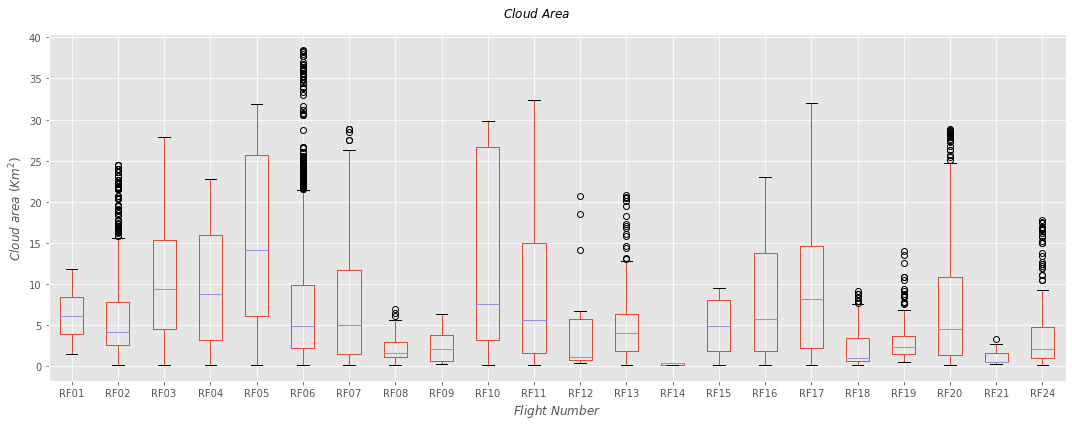

In [49]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['area_km2'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ area \ (Km^{2})$')
plt.suptitle('$Cloud \ Area$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/area.jpg', dpi=300)
plt.show()

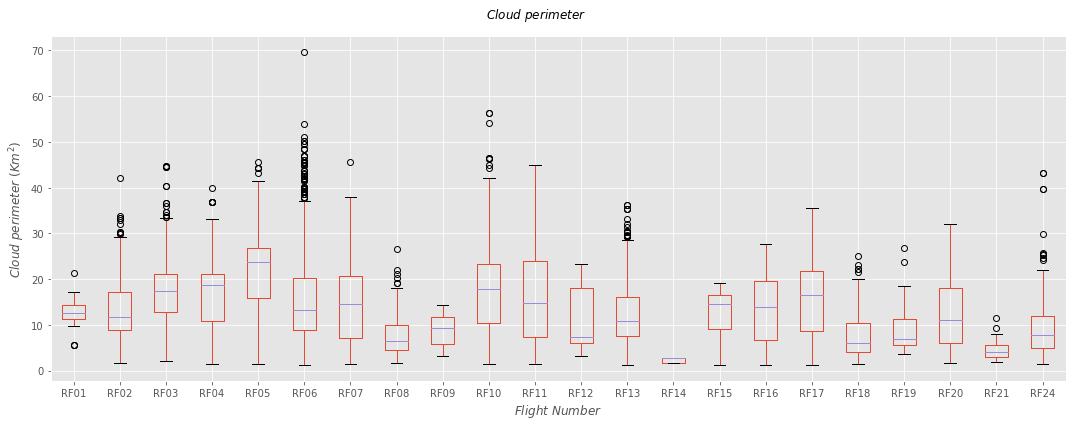

In [50]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['perimeter_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
plt.suptitle('$Cloud \ perimeter$')
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ perimeter \ (Km^{2})$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/peri.jpg', dpi=300)
plt.show()

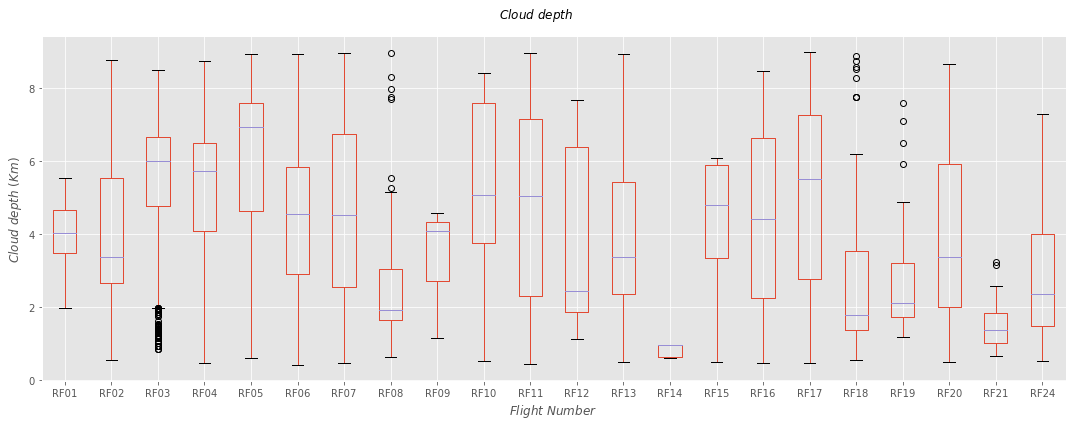

In [51]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['depth_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ depth \ (Km)$')
plt.suptitle('$Cloud \ depth$')
plt.title('')
plt.tight_layout()
plt.savefig('../results/cloud_depth.jpg', dpi=300)
plt.show()

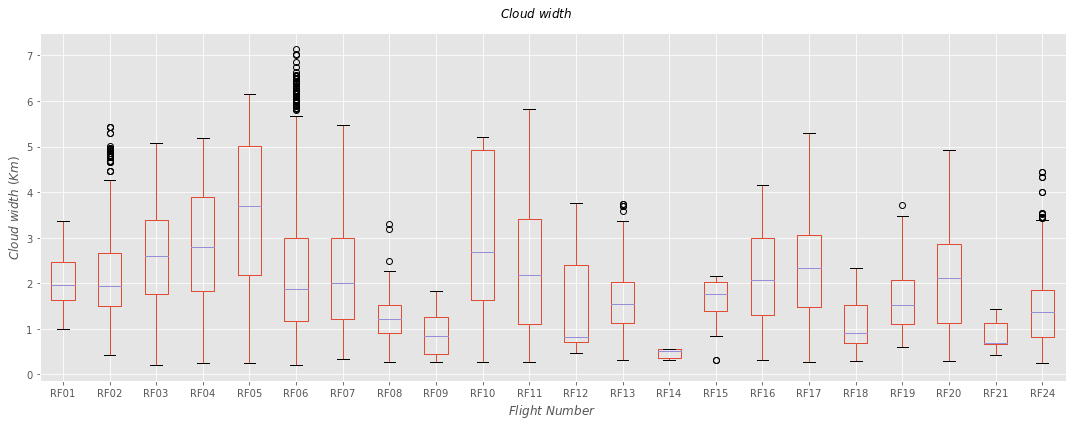

In [52]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['width_km'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ width \ (Km)$')
plt.suptitle('$Cloud \ width$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_width.jpg', dpi=300)
plt.show()

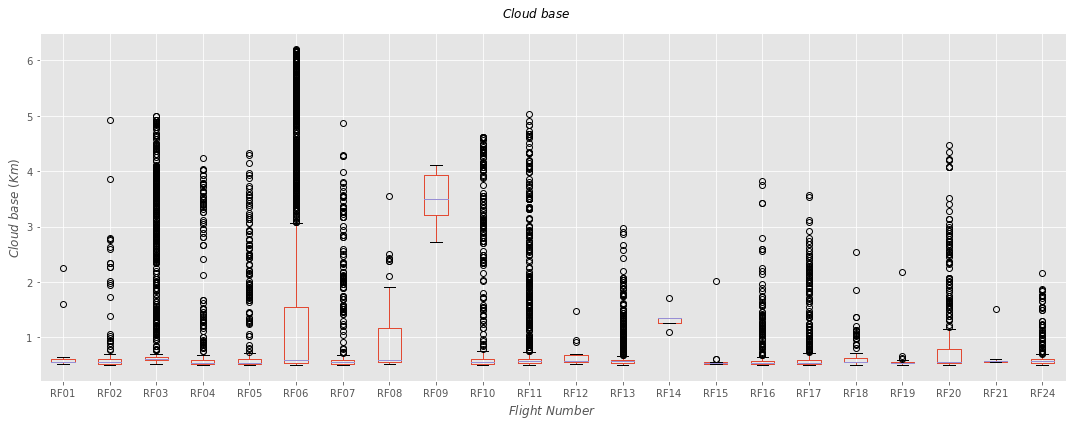

In [53]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['cloud_base'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ base \ (Km)$')
plt.suptitle('$Cloud \ base$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_base.jpg')
plt.show()

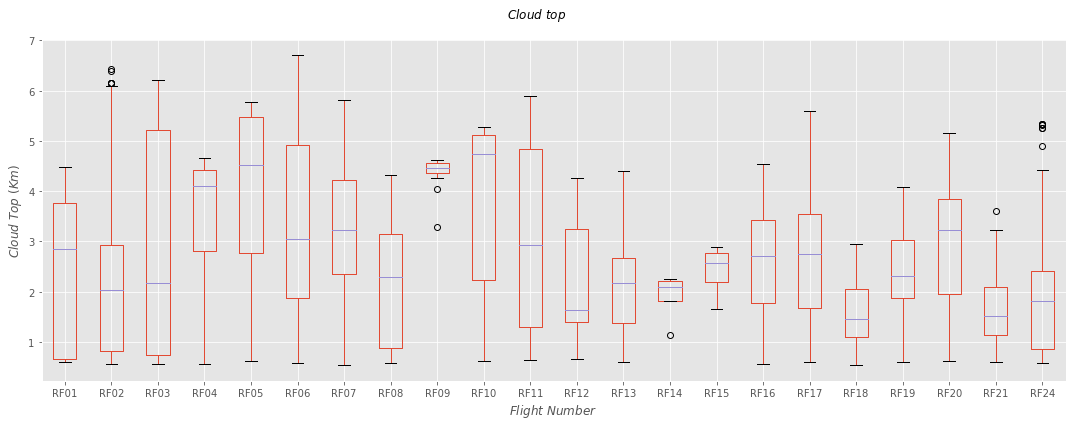

In [54]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['cloud_top'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ Top \ (Km)$')
plt.suptitle('$Cloud \ top$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/cloud_top.jpg', dpi=300)
plt.show()

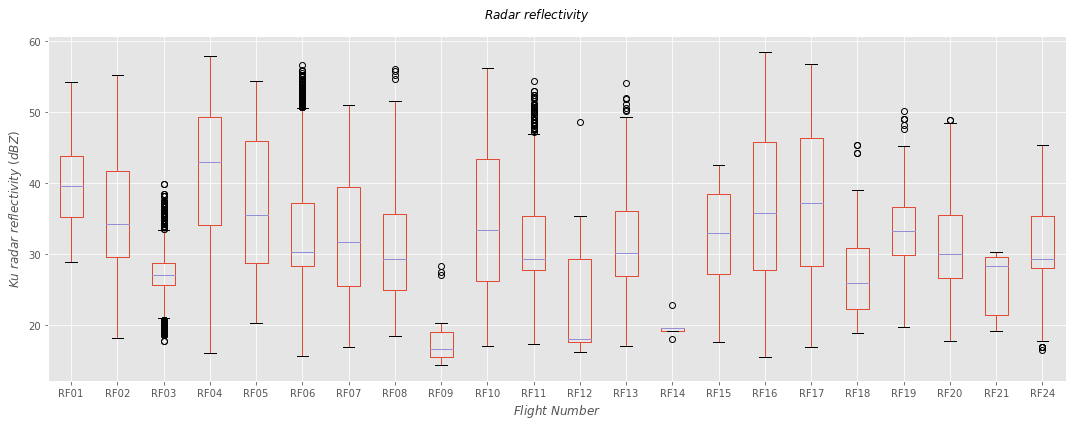

In [55]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['max_zhh'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Ku \ radar \ reflectivity \ (dBZ)$')
plt.suptitle('$Radar \ reflectivity$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/radar_ref.jpg', dpi=300)
plt.show()

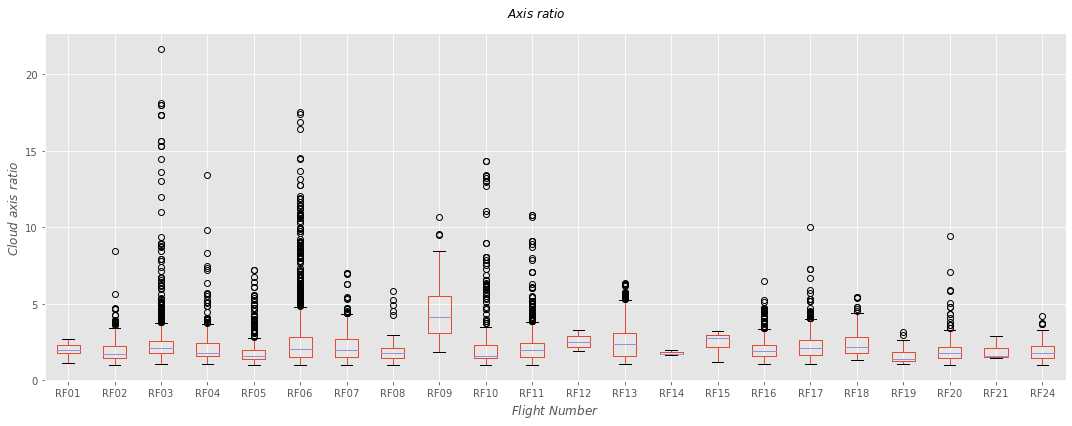

In [56]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['axis_ratio'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ axis \ ratio$')
plt.suptitle('$Axis \ ratio$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/Axis_ratio.jpg', dpi=300)
plt.show()

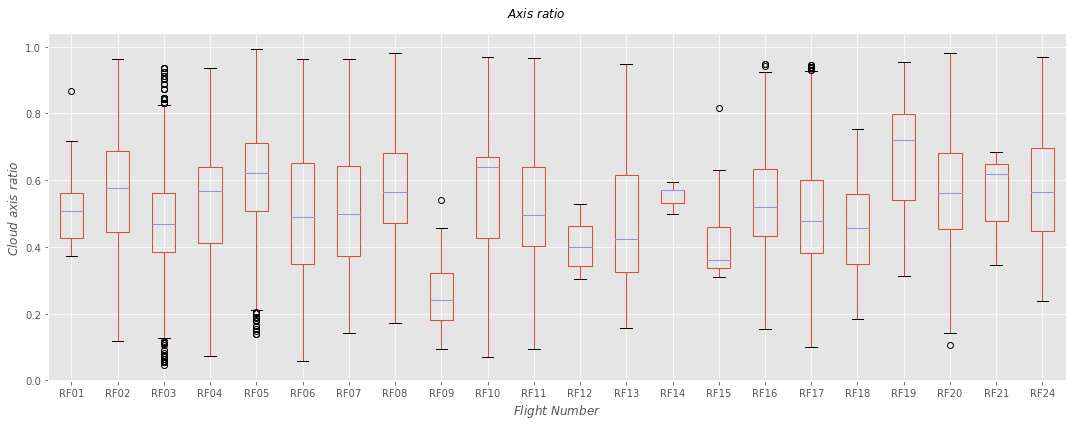

In [57]:
fig, ax = plt.subplots( figsize=(15, 6))
axis = df.boxplot(column=['axis_ratio_inv'], by=['vuelo'], ax=ax)
x_lab = [i for i in dict_flights.keys()]
axis.set_xlabel('$Flight \ Number$')
axis.set_ylabel('$Cloud \ axis \ ratio$')
plt.suptitle('$Axis \ ratio$')
plt.title('')
plt.tight_layout()

plt.savefig('../results/Axis_ratio_inv.jpg', dpi=300)
plt.show()

In [58]:
times = df.depth_km.nlargest(10).index
cond = df[(df.depth_km > 9) & (df.area_km2 < 7)].index

2019-08-24 23:05:44.899800


/tmp/ipykernel_137440/1437687236.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')


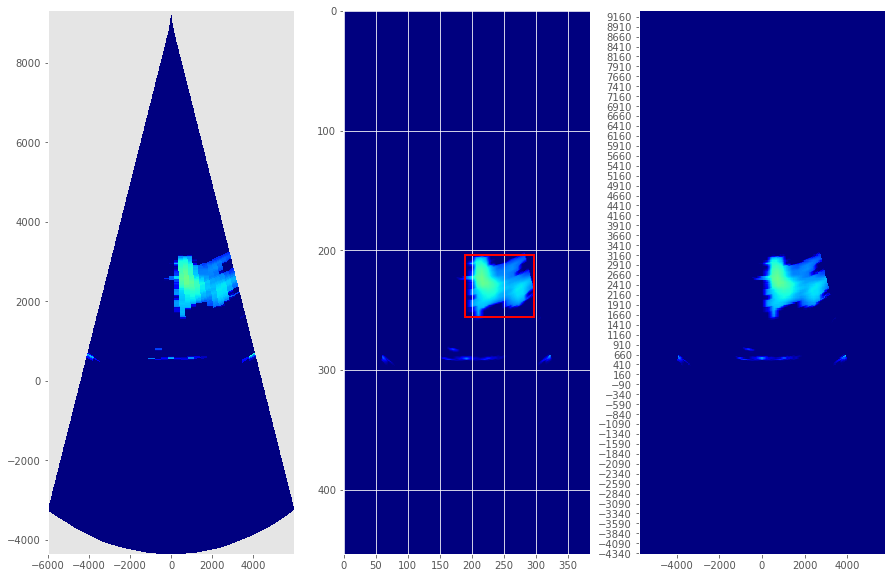

a
2019-08-24 23:05:46.749800


/tmp/ipykernel_137440/1437687236.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')


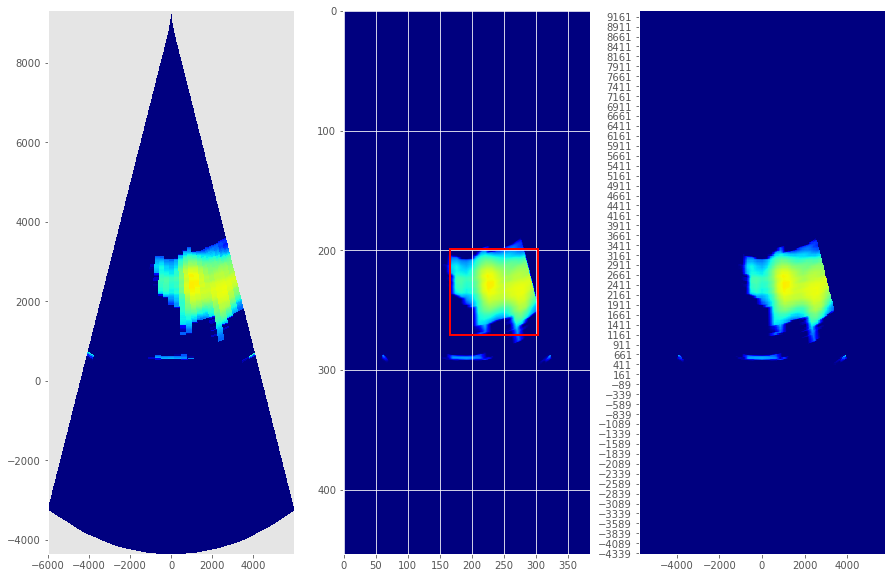

a
2019-08-24 23:05:48.599800


/tmp/ipykernel_137440/1437687236.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')


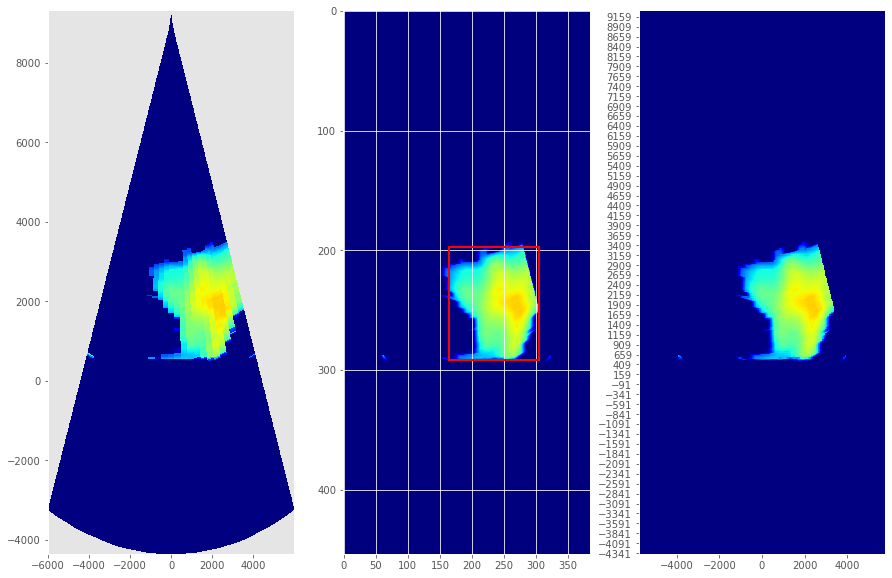

a
2019-08-24 23:05:50.449800


/tmp/ipykernel_137440/1437687236.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')


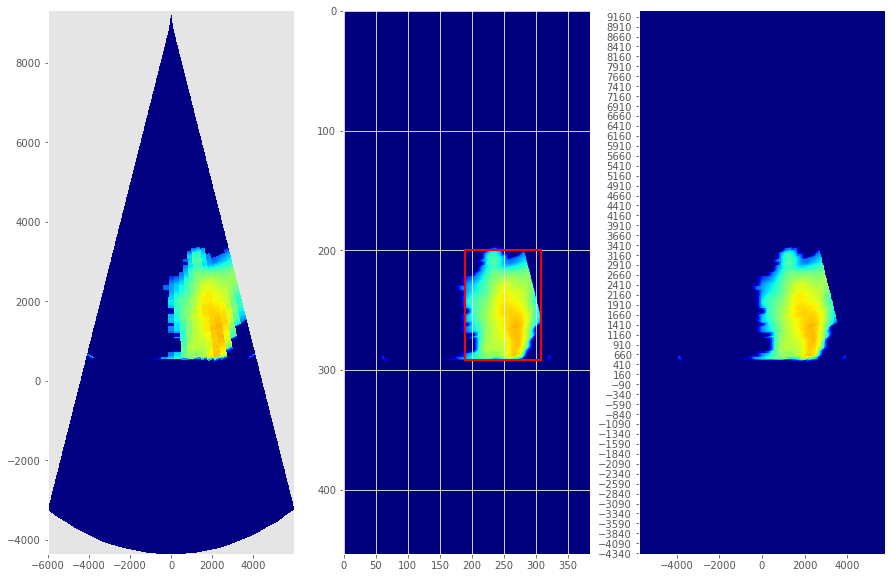

a


In [64]:
for i in clip:
    print(i)
    ds_data = ds_xr[['zhh14', 'azimuth', 'DR']].sel(time=i)
    ds_zhh = ds_data.zhh14.where(ds_data.alt3d > 500)
    process_new(zhh14=ds_zhh, _range=ds_data.range, azimuth=ds_data.azimuth,
                alt3d=ds_data.alt3d, bin_size=ds_data.DR, time=ds_data.time)

In [60]:
df.width_km.nlargest(10)

time
2019-09-07 06:33:02.699800    7.141056
2019-09-07 06:33:04.549800    7.025403
2019-09-07 06:33:00.849800    7.000034
2019-09-07 06:33:06.399800    6.858551
2019-09-07 07:01:08.949800    6.738850
2019-09-07 06:33:08.249800    6.644902
2019-09-07 06:34:12.999800    6.572405
2019-09-07 06:34:12.999800    6.572405
2019-09-07 06:34:11.149800    6.556300
2019-09-07 06:34:11.149800    6.556300
Name: width_km, dtype: float64

In [65]:
df.area_km2[clip]

time
2019-08-24 23:05:44.899800    3.1698
2019-08-24 23:05:46.749800    6.1299
2019-08-24 23:05:48.599800    8.5005
2019-08-24 23:05:50.449800    8.3772
Name: area_km2, dtype: float64

In [68]:
df.area[clip]

time
2019-08-24 23:05:44.899800    3522.0
2019-08-24 23:05:46.749800    6811.0
2019-08-24 23:05:48.599800    9445.0
2019-08-24 23:05:50.449800    9308.0
Name: area, dtype: float64

In [2]:
df_numpx = pd.read_csv('../results/num_px_202111070706.csv')
a = df_numpx.columns[0]
df_numpx.rename(columns={a: "time"}, inplace=True)
df_numpx.index = pd.to_datetime(df_numpx.time)
# df_numpx.drop('time', axis=1, inplace=True)

In [3]:
df_numpx = df_numpx[df_numpx.columns].apply(pd.to_numeric)

In [63]:
clip = df_numpx.loc['2019-08-24 23:05:44': '2019-08-24 23:05:50'].index

In [19]:
clip.to_csv('../results/cliped.csv')

In [ ]:
df_total = pd.read_csv('../results/all_px_202111070706.csv')
a = df_total.columns[0]
df_total.rename(columns={a: "time"}, inplace=True)
df_total.index = pd.to_datetime(df_total.time)
df_total.drop('time', axis=1, inplace=True)

In [ ]:
df_total = df_total[df_total.columns].apply(pd.to_numeric)

In [ ]:
df_wieght = df_numpx.div(df_total)

In [ ]:
df_area = df_wieght.mul( df_numpx)

In [ ]:
df_area_wg = df_area.sum(axis=0)

In [ ]:
df_area_wg.max() * 30 **2 / 1000 **2

In [ ]:
df.area.iloc[0]